In [1]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv2D, ReLU, BatchNormalization, ZeroPadding2D
from tensorflow.keras.layers import MaxPooling2D, Dense, Add, GlobalAveragePooling2D

In [0]:
def stem(inputs):

    # The 224x224 images are zero padded (black - no signal) to be 230x230 images prior to the first convolution
    x = ZeroPadding2D(padding=(3, 3))(inputs)
    
    # First Convolutional layer which uses a large (coarse) filter 
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='valid', use_bias=False, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    # Pooled feature maps will be reduced by 75%
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)
    return x
    
def learner(x, groups):

    # First Residual Block Group (not strided)
    n_filters, n_blocks = groups.pop(0)
    x = group(x, n_filters, n_blocks, strides=(1, 1))

    # Remaining Residual Block Groups (strided)
    for n_filters, n_blocks in groups:
    	x = group(x, n_filters, n_blocks)
    return x

def group(x, n_filters, n_blocks, strides=(2, 2)):

    # Double the size of filters to fit the first Residual Group
    x = projection_block(x, n_filters, strides=strides)

    # Identity residual blocks
    for _ in range(n_blocks):
        x = identity_block(x, n_filters)
    return x

def identity_block(x, n_filters):

    # Save input vector (feature maps) for the identity link
    shortcut = x
    
    ## Construct the 1x1, 3x3, 1x1 residual block (fig 3c)

    # Dimensionality reduction
    x = Conv2D(n_filters, (1, 1), strides=(1, 1), use_bias=False, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Bottleneck layer
    x = Conv2D(n_filters, (3, 3), strides=(1, 1), padding="same", use_bias=False, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Dimensionality restoration - increase the number of output filters by 4X
    x = Conv2D(n_filters * 4, (1, 1), strides=(1, 1), use_bias=False, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)

    # Add the identity link (input) to the output of the residual block
    x = Add()([shortcut, x])
    x = ReLU()(x)
    return x

def projection_block(x, n_filters, strides=(2,2)):

    # Construct the projection shortcut
    # Increase filters by 4X to match shape when added to output of block
    shortcut = Conv2D(4 * n_filters, (1, 1), strides=strides, use_bias=False, kernel_initializer='he_normal')(x)
    shortcut = BatchNormalization()(shortcut)

    ## Construct the 1x1, 3x3, 1x1 residual block (fig 3c)

    # Dimensionality reduction
    # Feature pooling when strides=(2, 2)
    x = Conv2D(n_filters, (1, 1), strides=strides, use_bias=False, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Bottleneck layer
    x = Conv2D(n_filters, (3, 3), strides=(1, 1), padding='same', use_bias=False, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Dimensionality restoration - increase the number of filters by 4X
    x = Conv2D(4 * n_filters, (1, 1), strides=(1, 1), use_bias=False, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)

    # Add the projection shortcut link to the output of the residual block
    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

def classifier(x, n_classes):

  # Pool at the end of all the convolutional residual blocks
  x = GlobalAveragePooling2D()(x)

  # Final Dense Outputting Layer for the outputs
  outputs = Dense(n_classes, activation='softmax', kernel_initializer='he_normal')(x)
  return outputs

def Resnet():
  # Meta-parameter: list of groups: number of filters and number of blocks
  groups = { 50 : [ (64, 3), (128, 4), (256, 6),  (512, 3) ],		# ResNet50
           101: [ (64, 3), (128, 4), (256, 23), (512, 3) ],		# ResNet101
           152: [ (64, 3), (128, 8), (256, 36), (512, 3) ]		# ResNet152
         }

  # The input tensor
  inputs = Input(shape=(32, 32, 3))

  # The stem convolutional group
  x = stem(inputs)

  # The learner
  x = learner(x, groups[50])

  # The classifier for 100 classes
  outputs = classifier(x, 10)

  # Instantiate the Model
  model = Model(inputs, outputs)

  return model


In [3]:
model = Resnet()
#print(model.summary())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Height =23092, Width =1269, Channels =3


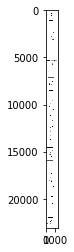

In [4]:
import tensorflow
tensorflow.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt

im = cv2.imread('model_plot.png')
height, width, channels = im.shape
print("Height =%d, Width =%d, Channels =%d"%(height,width,channels))
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()

In [0]:
import tensorflow
opt = tensorflow.keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)
sgd = tensorflow.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adam = tensorflow.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

In [6]:
from tensorflow.keras.datasets import cifar10
#(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')
(x_train, y_train), (x_test, y_test) = cifar10.load_data()


from termcolor import colored
def show_shapes(x_train, y_train, x_test, y_test, color='green'):
    print(colored('Training shape:', color, attrs=['bold']))
    print('  x_train.shape:', x_train.shape)
    print('  y_train.shape:', y_train.shape)
    print(colored('\nTesting shape:', color, attrs=['bold']))
    print('  x_test.shape:', x_test.shape)
    print('  y_test.shape:', y_test.shape)

show_shapes(x_train, y_train, x_test, y_test)

Training shape:
  x_train.shape: (50000, 32, 32, 3)
  y_train.shape: (50000, 1)

Testing shape:
  x_test.shape: (10000, 32, 32, 3)
  y_test.shape: (10000, 1)


In [7]:
from keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

#(x_train, y_train), (x_test, y_test)
batch_size = 32
epochs = 25
NUM_CLASSES = 10
print(y_train.shape)
#y_train = to_categorical(y_train, NUM_CLASSES)
#y_test = to_categorical(y_test, NUM_CLASSES)
print(y_train.shape)


x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.0
x_test /= 255.0

import os, os.path,shutil
base_dir = 'Data'
os.makedirs(base_dir, exist_ok=True)

checkpoint = ModelCheckpoint(base_dir+ "Best_Weights.h5", monitor='val_acc',
                             verbose=1,save_best_only=True, mode='auto',
                             period=1)

history = model.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data=(x_test, y_test),
                verbose=1,
                callbacks=[checkpoint],
                shuffle=True)

(50000, 1)
(50000, 1)


Using TensorFlow backend.


Train on 50000 samples, validate on 10000 samples
Epoch 1/25
49952/50000 [============================>.] - ETA: 0s - loss: 2.2085 - acc: 0.3252
Epoch 00001: val_acc improved from -inf to 0.39000, saving model to DataBest_Weights.h5
50000/50000 [==============================] - 114s 2ms/sample - loss: 2.2088 - acc: 0.3253 - val_loss: 3.0047 - val_acc: 0.3900
Epoch 2/25
49952/50000 [============================>.] - ETA: 0s - loss: 2.2520 - acc: 0.3046
Epoch 00002: val_acc did not improve from 0.39000
50000/50000 [==============================] - 82s 2ms/sample - loss: 2.2528 - acc: 0.3046 - val_loss: 2.0183 - val_acc: 0.2273
Epoch 3/25
49984/50000 [============================>.] - ETA: 0s - loss: 2.0695 - acc: 0.3440
Epoch 00003: val_acc improved from 0.39000 to 0.40760, saving model to DataBest_Weights.h5
50000/50000 [==============================] - 83s 2ms/sample - loss: 2.0695 - acc: 0.3440 - val_loss: 1.6419 - val_acc: 0.4076
Epoch 4/25
49984/50000 [===========================

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


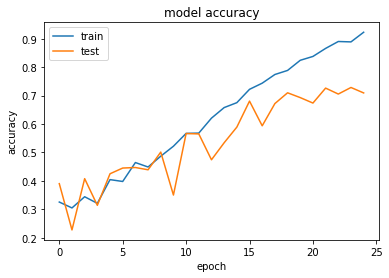

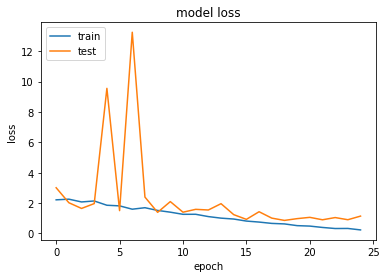

In [8]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [9]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
model.load_weights("DataBest_Weights.h5")
predict = model.predict(x_test)
print(predict.shape)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true = y_test, y_pred = predict.argmax(axis=1))
print(cm)

from sklearn.metrics import classification_report
print(classification_report(y_test, predict.argmax(axis=1)))

(10000, 10)
[[802  26  31   4  11   1   6  10  57  52]
 [ 20 859   1   1   2   1   6   3  16  91]
 [ 79  10 590  41  91  34  62  38  31  24]
 [ 41  34  72 391 116  80  85  66  53  62]
 [ 32   7  52  28 739  19  20  73  17  13]
 [ 30  17  61 151  92 447  34  92  44  32]
 [ 22  18  24  24  70  20 762   8  26  26]
 [ 19   4  28  24  62  18   3 802   3  37]
 [ 69  34   4   3   6   0   1   3 856  24]
 [ 36  78   2   3   2   1   5   9  21 843]]
              precision    recall  f1-score   support

           0       0.70      0.80      0.75      1000
           1       0.79      0.86      0.82      1000
           2       0.68      0.59      0.63      1000
           3       0.58      0.39      0.47      1000
           4       0.62      0.74      0.67      1000
           5       0.72      0.45      0.55      1000
           6       0.77      0.76      0.77      1000
           7       0.73      0.80      0.76      1000
           8       0.76      0.86      0.81      1000
           9    